In [1]:
# !pip install -e .

In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer, GaussianRasterizerJax
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp
from random import randint
import jax
from jax.scipy.spatial.transform import Rotation as R

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

I0000 00:00:1704745889.311388   39551 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


device(type='cuda')

In [2]:
def getProjectionMatrix(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P


intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)

def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )
def apply_transform(points, transform):
    rels_ = torch.cat(
        (
            points,
            torch.ones((points.shape[0], 1),  device=device),
        ),
        1,
    )
    return torch.einsum("ij, aj -> ai", transform, rels_)[...,:3]


def intrinsics_to_rasterizer(intrinsics, camera_pose_jax):

    fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2.0
    fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2.0
    tan_fovx = math.tan(fovX)
    tan_fovy = math.tan(fovY)

    proj_matrix = getProjectionMatrix(0.01, 100.0, fovX, fovY).transpose(0,1).cuda()
    view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose_jax))),0,1).cuda()

    raster_settings = GaussianRasterizationSettings(
        image_height=int(intrinsics.height),
        image_width=int(intrinsics.width),
        tanfovx=tan_fovx,
        tanfovy=tan_fovy,
        bg=torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0]).cuda(),
        scale_modifier=1.0,
        viewmatrix=view_matrix,
        projmatrix=view_matrix @ proj_matrix,
        sh_degree=0,
        campos=torch.zeros(3).cuda(),
        prefiltered=False,
        debug=None
    )
    # rasterizer = GaussianRasterizerJax(raster_settings=raster_settings)
    rasterizer = GaussianRasterizer(raster_settings=raster_settings)
    return rasterizer

In [3]:
# b.setup_visualizer()

In [4]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)

In [5]:
default_seed = 1222
gt_seed = 1208

In [6]:
torch.manual_seed(gt_seed)
import random
random.seed(gt_seed)
np.random.seed(gt_seed)

N = 100

rasterizer = intrinsics_to_rasterizer(intrinsics, jnp.eye(4))
means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp_gt = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device).detach()
scales = torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)

color,radii = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp_gt,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)
# print(colors_precomp_gt)
print(color.min().item(), color.max().item(), color.mean().item())
print('\n')

color_gt = color.detach()
gt_viz = b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0)
gt_viz



TORCH GAUSSIAN RASTERIZER INIT


/tmp/ipykernel_39551/2402439589.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

/tmp/ipykernel_38831/2454237893.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
/tmp/ipykernel_38831/2454237893.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
/tmp/ipykernel_38831/2454237893.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
/tmp/ipykernel_388

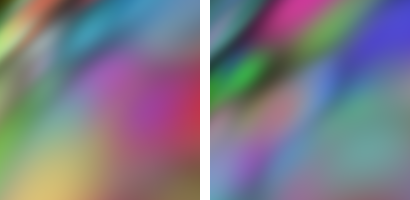

In [ ]:
torch.manual_seed(default_seed)
import random
random.seed(default_seed)
np.random.seed(default_seed)

means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
scales = torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)
color,_ = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)

b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0),
    gt_viz
])

0.004555233754217625: 100%|██████████| 600/600 [00:01<00:00, 323.68it/s] 


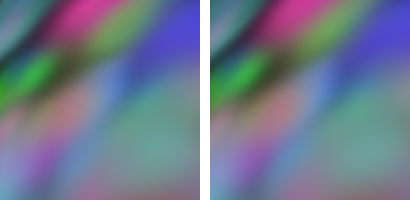

: 

In [ ]:
torch.manual_seed(default_seed)
import random
random.seed(default_seed)
np.random.seed(default_seed)

optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    {'params': [means3D], 'lr': 0.001, "name": "pos"},
], lr=0.0, eps=1e-15)

it = 50
pbar = tqdm(range(it))
for _ in pbar:
    color,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
    
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0),
    gt_viz
])

0.023603683337569237:   6%|▌         | 33/600 [00:00<00:01, 321.45it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.024019213393330574:   6%|▌         | 33/600 [00:00<00:01, 321.45it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02737502008676529:  16%|█▋        | 98/600 [00:00<00:01, 300.64it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02462419494986534:  16%|█▋        | 98/600 [00:00<00:01, 300.64it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02426442690193653:  26%|██▋       | 159/600 [00:00<00:01, 296.16it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.026430362835526466:  26%|██▋       | 159/600 [00:00<00:01, 296.16it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.025271646678447723:  36%|███▋      | 219/600 [00:00<00:01, 289.84it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02470501698553562:  36%|███▋      | 219/600 [00:00<00:01, 289.84it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02329275757074356:  46%|████▋     | 278/600 [00:00<00:01, 289.96it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.0231704730540514:  46%|████▋     | 278/600 [00:01<00:01, 289.96it/s]  

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.024434193968772888:  56%|█████▋    | 339/600 [00:01<00:00, 293.67it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.023653533309698105:  56%|█████▋    | 339/600 [00:01<00:00, 293.67it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02446001023054123:  67%|██████▋   | 401/600 [00:01<00:00, 299.64it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.024054573848843575:  67%|██████▋   | 401/600 [00:01<00:00, 299.64it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.027621755376458168:  77%|███████▋  | 463/600 [00:01<00:00, 300.72it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02791326679289341:  77%|███████▋  | 463/600 [00:01<00:00, 300.72it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02688293345272541:  88%|████████▊ | 525/600 [00:01<00:00, 300.76it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02510428987443447:  88%|████████▊ | 525/600 [00:01<00:00, 300.76it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.0254441499710083:  98%|█████████▊| 587/600 [00:01<00:00, 301.68it/s]  

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02420882135629654: 100%|██████████| 600/600 [00:02<00:00, 297.68it/s] 


Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

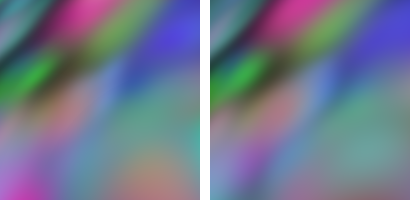

In [ ]:
default_seed = 1
torch.manual_seed(default_seed)
import random
random.seed(default_seed)
np.random.seed(default_seed)

optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    {'params': [means3D], 'lr': 0.001, "name": "pos"},
], lr=0.0, eps=1e-15)

it = 50
pbar = tqdm(range(it))
for _ in pbar:
    color,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0),
    gt_viz
])